### 프로젝트 : 한국어 QA 모델 만들기
- 한국어 버전의 bAbi 데이터 셋
https://aiffelstaticprd.blob.core.windows.net/media/documents/e-28-korean.zip

#### STEP 1) 한국어 형태소 분석기_토크나이저 변경하기
- 사용자 사전이 추가된 Customized Konlpy 사용
https://inspiringpeople.github.io/data%20analysis/ckonlpy/

In [1]:
#!pip install customized_konlpy

In [2]:
# 예시 코드
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')

/home/aiffel/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은경이', '는', '사무실', '로', '갔습니다', '.']

#### STEP 2) 한국어 분석 후 불용어 처리하기
- '는' , '으로' 등 분석에 도움이 되지 않는 토큰들 -> 불용어 처리로 제외

#### STEP 3) 한국어에서의 모델 정확도 확인해보기


#### 평가문항	
1. 한국어의 특성에 알맞게 전처리가 진행되었다.
    - 한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.
2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다.
    - validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다.
3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다.
    - 추론 태스크의 테스트 정확도가 90% 이상 달성하였다.

In [3]:
# 라이브러리 불러오기
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [8]:
# # 데이터 불러오기
# # 환경에 맞게 경로 수정
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'
# file_to_save = home_dir + '/babi-tasks-v1-2.tar.gz'
# path = get_file(file_to_save, origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
# print(path)

In [5]:
# # 압축해제
# with tarfile.open(path) as tar:
#     tar.extractall(home_dir)  # ~/aiffel/babi_memory_net 아래에 압축해제
#     tar.close()

In [9]:
# 훈련데이터 및 테스트 데이터 경로 지정
# 환경에 맞게 경로 적절히 수정
DATA_DIR = home_dir 
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [10]:
# 훈련데이터에서 20개 문장 출력
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


### 데이터 전처리 1) 기본 전처리

In [11]:
#데이터 전처리 
#기본 전처리
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [12]:
#read_data() -> 스토리,질문,답변의 쌍을 리턴하는 훈련데이터 => train_data()에 저장
#테스트 데이터는 => test_data()에 저장

train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [13]:
#전처리 후 데이터셋 크기 출력
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [14]:
type(train_data)

tuple

In [15]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [16]:
#3878번째 스토리 출력
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

In [17]:
#상위 5개의 질문 출력
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [18]:
#상위 5개의 답변 출력
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

In [19]:
#토큰화를 위한 함수 선언
def tokenize(sent):
    return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
    # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

In [20]:
from konlpy.tag import Twitter as OriginalTwitter

# def tokenize(sent):
#     twitter_original = OriginalTwitter()
#     return [twitter_original.pos(sent),'\n']

# from ckonlpy.tag import Twitter
# twitter.add_dictionary('아이오아이', 'Noun')
# print(twitter.pos('우리아이오아이는 정말 이뻐요'))

In [21]:
# from ckonlpy.tag import Postprocessor

# ## 파일을 로딩해서 전처리 하기 ##
# from ckonlpy.utils import load_wordset
# passwords = load_wordset('./passwords.txt')
# stopwords = load_wordset('./stopwords.txt')

# from ckonlpy.utils import load_replace_wordpair
# replace = load_replace_wordpair('./replacewords.txt')

# from ckonlpy.utils import load_ngram
# ngrams = load_ngram('./ngrams.txt')
# ####################################

# postprocessor = Postprocessor(
#     base_tagger = twitter, # base tagger
#     stopwords = stopwords, # 해당 단어 필터
#     passwords = passwords, # 해당 단어만 선택
#     passtags = passtags, # 해당 품사만 선택
#     replace = replace, # 해당 단어 set 치환
#     ngrams = ngrams # 해당 복합 단어 set을 한 단어로 결합
# )

# print(passwords)
# print(stopwrods)
# print(replace)
# print(ngrams)

In [22]:
# def tokenize(sent):
#     from konlpy.tag import Okt  
#     okt=Okt()  
#     return [okt.morphs(sent)]

In [23]:
#주피터 노트북에서 파이썬 버전 확인하는 법
import sys

print("--sys.version—")
print(sys.version)

--sys.version—
3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


### 데이터 전처리 - 단어장 생성
- 단어 -> 정수 , 정수 -> 단어 로 맵핑하는 딕셔너리(dictionary) 생성
    - 스토리와 질문의 가장 긴 길이를 구하기 (패딩사용)

In [24]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [25]:
#단어장과 가장 긴 샘플의 길이를 리턴 
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [26]:
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [27]:
#단어장의 크기는 패딩을 고려하여 +1
vocab_size = len(word2idx) + 1

In [28]:
#bAbi 데이터셋의 특징 -> 대체로 매우 짧은 길이의 질문들로 구성됨
print('스토리의 최대 길이 :',story_max_len) # 스토리 내에 있는 여러 개 문장들을 하나의 문장으로 간주하였을 때, 최대 단어의 개수
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 40
질문의 최대 길이 : 3


### 데이터 전처리 2) 패딩, 정수인코딩, 벡터화
- 앞서 최대 길이를 구한 이유 => 패딩을 하기 위함
    -남은 전처리
        1. 현재 텍스트 데이터 => 단어와 맵핑되는 정수로인코딩 | word2idx활용
        2. 스토리와 질문 데이터 => 각각 최대 길이로 패딩(padding) | story_max_len,question_max_len을 사용
        3. 레이블에 해당하는 정답 데이터 => 원-핫 인코딩 
        
    - vectorize()함수 선언을 통해 해당 기능 구현

In [29]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [30]:
#훈련 데이터와 테스트 데이터에 대해서 함수를 호출
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [31]:
#반환된 결과의 크기(shape)를 확인
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 40) (10000, 3) (10000, 25) (1000, 40) (1000, 3) (1000, 25)


### 메모리 네트워크 구현

In [32]:
#라이브러리 불러오기
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In /home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/aiffel/anaconda3/lib/python3.7/site-packages/matplo

In [33]:
#하이퍼파라미터 정의
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [34]:
#입력을 담을 변수 정의
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 40), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 3), dtype=float32)


In [35]:
#!pip install IPython 

In [36]:
from IPython.display import Image

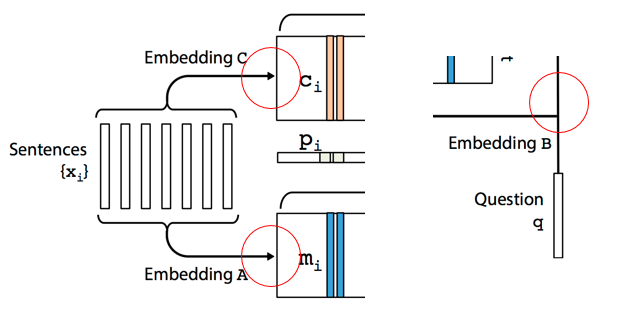

In [37]:
Image('network.png')

In [38]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩

In [39]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [40]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m Tensor("sequential/dropout/cond/Identity:0", shape=(None, 40, 50), dtype=float32) 

Input encoded c Tensor("sequential_1/dropout_1/cond/Identity:0", shape=(None, 40, 3), dtype=float32) 

Question encoded Tensor("sequential_2/dropout_2/cond/Identity:0", shape=(None, 3, 50), dtype=float32) 



In [41]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/truediv:0", shape=(None, 40, 3), dtype=float32)


In [42]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
# 예측에 사용되는 출력 행렬은 매칭 유사도 match와 스토리 표현 input_encoded_c을 더해서 구함
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/transpose:0", shape=(None, 3, 40), dtype=float32)


In [43]:
# 모델 정의 및 훈련 수행
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/concat:0", shape=(None, 3, 90), dtype=float32)


In [44]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.9047 - acc: 0.1678 - val_loss: 1.7919 - val_acc: 0.2170
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6742 - acc: 0.2702 - val_loss: 1.5101 - val_acc: 0.3610
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5236 - acc: 0.3590 - val_loss: 1.4818 - val_acc: 0.3710
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5020 - acc: 0.3808 - val_loss: 1.4337 - val_acc: 0.4280
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4217 - acc: 0.4288 - val_loss: 1.3352 - val_acc: 0.4750
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.3823 - acc: 0.4484 - val_loss: 1.3421 - val_acc: 0.4720
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.3687 - acc: 0.4550 - val_loss: 1.3166 - val_acc: 0.4770
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.0525 - acc: 0.9833 - val_loss: 0.0638 - val_acc: 0.9750
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0443 - acc: 0.9859 - val_loss: 0.0438 - val_acc: 0.9850
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0446 - acc: 0.9856 - val_loss: 0.0258 - val_acc: 0.9890
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0397 - acc: 0.9874 - val_loss: 0.0170 - val_acc: 0.9960
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0323 - acc: 0.9911 - val_loss: 0.0175 - val_acc: 0.9950
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0317 - acc: 0.9917 - val_loss: 0.0121 - val_acc: 0.9980
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0291 - acc: 0.9911 - val_loss: 0.0087 - val_acc: 0.9980
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [45]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 1ms/step - loss: 1.0482e-04 - acc: 1.0000

 테스트 정확도: 1.0000


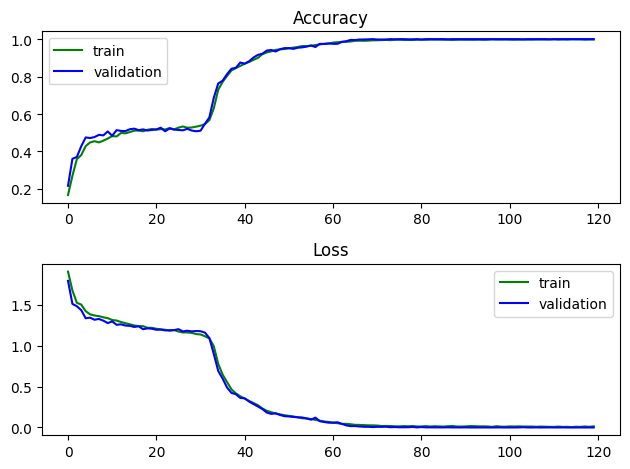

In [46]:
# 훈련 히스토리 시각화

# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [47]:
#테스트 데이터에서 실제 예측결과 확인 

NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이는 어디야 ?          : 복도       복도
필웅이는 어디야 ?          : 화장실      화장실
경임이는 어디야 ?          : 부엌       부엌
경임이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 부엌       부엌
경임이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 정원       정원
수종이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 사무실      사무실
수종이는 어디야 ?          : 사무실      사무실
필웅이는 어디야 ?          : 부엌       부엌
필웅이는 어디야 ?          : 정원       정원
수종이는 어디야 ?          : 사무실      사무실
필웅이는 어디야 ?          : 침실       침실
필웅이는 어디야 ?          : 침실       침실
은경이는 어디야 ?          : 부엌       부엌
은경이는 어디야 ?          : 정원       정원
은경이는 어디야 ?          : 부엌       부엌
수종이는 어디야 ?          : 사무실      사무실
은경이는 어디야 ?          : 부엌       부엌
필웅이는 어디야 ?          : 복도       복도
은경이는 어디야 ?          : 사무실      사무실
은경이는 어디야 ?          : 사무실      사무실
경임이는 어디야 ?          : 복도       복도
수종이는 어디야 ?          : 침실       침실
경임이는 어디야 ?          : 침실       침실
필웅이는 어디야 ?          : 침실       침실
수종

### 회고
- 한국어 형태소 분석기를 활용한 토크나이저 적용이 안되었다.
- 한국어 전처리 와 임베딩 방법에 대해서 더 공부해야겠다.
- 모델 성능이 거의 99% 가깝게 추론을 하였는데, 데이터셋의 분리문제인지 임베딩과 토큰화의 문제인지 잘 모르겠다.